In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

## $R^2$ for Bayesian regression models

In [R-squared for Bayesian Regression Models](https://www.tandfonline.com/doi/abs/10.1080/00031305.2018.1549100) by Gelman et al. (2018),
the authors propose a generalization of the classical coefficient of determination $R^2$ to Bayesian regression models.

The coefficient of determination they propose is defined as:

$$
\frac{\text{Explained variance}}{\text{Explained variance} + \text{Residual variance}} = \frac{\text{var}_\text{fit}}{\text{var}_\text{fit} + \text{var}_\text{res}}
$$

where $\text{var}_\text{fit}$ and $\text{var}_\text{res}$ are computed as:

$$
\begin{aligned}
\text{var}_\text{fit} &= \text{V}\left(\mathbb{E}(\tilde{y}_i \mid \boldsymbol{x}_i, \boldsymbol{\theta})\right) =  \text{V} \left(y_i^\text{pred}\right) \\
\text{var}_\text{res} &= \text{M}\left(\mathbb{V}\left(\tilde{y}_i - y_i^\text{pred} \mid \boldsymbol{x}_i, \boldsymbol{\theta}\right) \right)
\end{aligned}
$$

where $M$ and $V$ denote the sample mean and variance operators, respectively.

The first term is the variance of the expectation of future data and the second one is the expected variance of future residuals.

This Bayesian $R^2$ is conditional on the explanatory variables and the model parameters $\boldsymbol{\theta}$.
For this reason, this $R^2$ is proposed as an _a posteriori_ mesasure of model fit.

If we have draws from the posterior distribution, we can compute the Bayesian $R^2$ for each draw.

### Common cases

In the case of normal regression models, the components of the Bayesian $R^2$ simplify to:

$$
\begin{aligned}
\text{var}_\text{fit} &= \text{V}(\mu_i) \\
\text{var}_\text{res} &= \sigma^2
\end{aligned}
$$

where $\mu_i = \boldsymbol{x}_i^T \boldsymbol{\beta}$.

And for logistic regression models, they become:

$$
\begin{aligned}
\text{var}_\text{fit} &= \text{V}(\pi_i) \\
\text{var}_\text{res} &= \text{M}(\pi_i (1 - \pi_i))
\end{aligned}
$$

where $\pi_i = \text{expit}(\boldsymbol{x}_i^T \boldsymbol{\beta})$.

## The R2-D2 prior

The R2-D2 prior for normal regression models has been introduced in the paper 
[Bayesian Regression Using a Prior on the Model Fit: The R2-D2 Shrinkage Prior](https://arxiv.org/abs/1609.00046) by Zhang et al. (2016).

Consider the normal regression model:

$$
\begin{aligned}
Y_i \mid \mu_i, \sigma^2 &\underset{iid}{\sim} \text{Normal}(\mu_i, \sigma^2) \\
\mu_i &= \alpha + \beta_1 X_{1i} + \beta_2 X_{2i} + \dots + \beta_p X_{pi} \\
&= \alpha + \boldsymbol{X}\boldsymbol{\beta}
\end{aligned}
$$

where $\boldsymbol{X}$ is the $n \times p$ design matrix (without the intercept), $\alpha$ is the intercept term, and $\boldsymbol{\beta}$, of length $p$, is the vector of coefficients.

The central idea in the R2-D2 prior is to place a prior directly on the coefficient of determination $R^2$.
For the purpose of defining prior distributions, however, Zhang et al. work with the **marginal** coefficient of determination: a version of $R^2$ that averages over both the design matrix $\boldsymbol{X}$ and the regression coefficients $\boldsymbol{\beta}$, rather than the conditional coefficient of determination proposed by Gelman et al, that we mentioned above.

For the linear regression model, the marginal $R^2$ is defined as:

$$
R^2 = \frac{\mathbb{V}(\boldsymbol{x}^T \boldsymbol{\beta})}{\mathbb{V}(\boldsymbol{x}^T \boldsymbol{\beta}) + \sigma^2}
= \frac{\sigma^2 W}{\sigma^2 W + \sigma^2}
= \frac{W}{W + 1}
$$

which is the ratio of the marginal variance of the linear predictor to the marginal variance of the outcome.

Then, the R2-D2 prior is specified as:

$$
\begin{aligned}
\beta_j &\sim \text{Normal}(0, \phi_j W \sigma^2) \\
\boldsymbol{\phi} &\sim \text{Dirichlet}(\xi_1, \dots, \xi_p) \\
W & = \frac{R^2}{1 - R^2}\\
R^2 &\sim \text{Beta}(a, b) \\
\end{aligned}
$$

Through the transformation $W = R^2/(1-R^2)$, the prior on $R^2$ induces a prior on $W$, which governs the total prior variance of the linear predictor $\boldsymbol{x}^T \boldsymbol{\beta}$.
Combined with the Dirichlet prior on the variance proportions $\boldsymbol{\phi}$, this results in the $R^2$-induced Dirichlet Decomposition (R2-D2) prior.

It can be shown that the induced prior on $W$ is a Beta Prime distribution with parameters $a$ and $b$.

### PyMC implementation

To implement the R2-D2 prior in PyMC, let's first simulate some data with the following characteristics:

* $p = 30$, of which 4 are different from zero.
* $n = 1000$
* $\sigma^2 = 3^2$
* $X_i \sim \text{Uniform}(-2, 2)$, but then scaled to have variance 1

In [2]:
rng = np.random.default_rng(121195)

TRUE_ALPHA = 2.5
TRUE_BETAS = pm.draw(
    pm.Normal.dist(mu=[0] * 26 + [-2, 2] * 2, sigma=[0.05] * 26 + [0.5] * 4),
    random_seed=rng
)
TRUE_SIGMA = 3

n = 1000
p = len(TRUE_BETAS)

X = pm.draw(pm.Uniform.dist(lower=-2, upper=2, shape=p), draws=n, random_seed=rng)
X_std = X / X.std(0)
y = pm.draw(pm.Normal.dist(mu=TRUE_ALPHA + X_std @ TRUE_BETAS, sigma=TRUE_SIGMA), random_seed=rng)

In [3]:
X_std.shape, y.shape

((1000, 30), (1000,))

The classic coefficient of determination is computed via

$$
R^2 = \frac{\mathbb{V}(\boldsymbol{x}^T \boldsymbol{\beta})}{\mathbb{V}(\boldsymbol{x}^T \boldsymbol{\beta}) + \sigma^2}
$$

with

$$
\mathbb{V}(\boldsymbol{x}^T \boldsymbol{\beta}) = \boldsymbol{\beta}^T \text{Cov}(\boldsymbol{x}) \boldsymbol{\beta} = \boldsymbol{\beta}^T  \Sigma_{\boldsymbol{x}} \boldsymbol{\beta}
$$

In [4]:
Sigma = np.eye(p)
mu_var = (TRUE_BETAS.T @ Sigma @ TRUE_BETAS)
TRUE_R2 = mu_var / (mu_var + TRUE_SIGMA ** 2)
TRUE_R2

np.float64(0.5302817144658175)

Now, let's implement the model with the R2-D2 prior in PyMC.

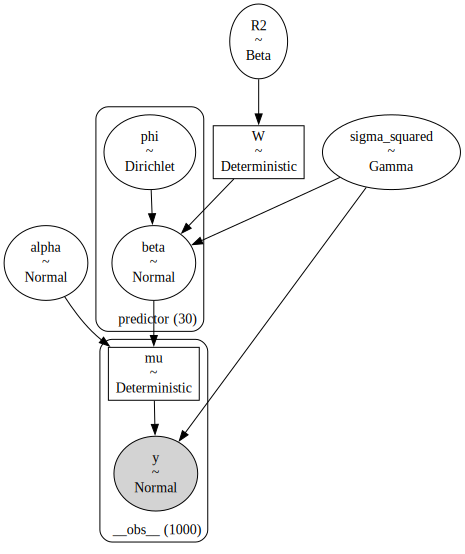

In [5]:
coords = {
    "predictor": np.arange(p),
    "__obs__": np.arange(n)
}

with pm.Model(coords=coords) as model_r2d2:
    R2 = pm.Beta("R2", alpha=2, beta=2)
    phi = pm.Dirichlet("phi", a=np.ones(p), dims="predictor")
    W = pm.Deterministic("W", R2 / (1 - R2))

    sigma_squared = pm.Gamma("sigma_squared", mu=9, sigma=3) # Informative
    alpha = pm.Normal("alpha")
    beta = pm.Normal("beta", mu=0, sigma=(phi * W * sigma_squared) ** 0.5, dims="predictor")
    mu = pm.Deterministic("mu", alpha + (X_std @ beta), dims="__obs__")

    pm.Normal("y", mu=mu, sigma=sigma_squared ** 0.5, observed=y, dims="__obs__")

model_r2d2.to_graphviz()

In [6]:
with model_r2d2:
    idata_r2d2 = pm.sample(random_seed=121195, target_accept=0.99)

Initializing NUTS using jitter+adapt_diag...
/home/tomas/miniconda3/envs/pymc-env/lib/python3.13/site-packages/pytensor/link/c/cmodule.py:3004: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [R2, phi, sigma_squared, alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


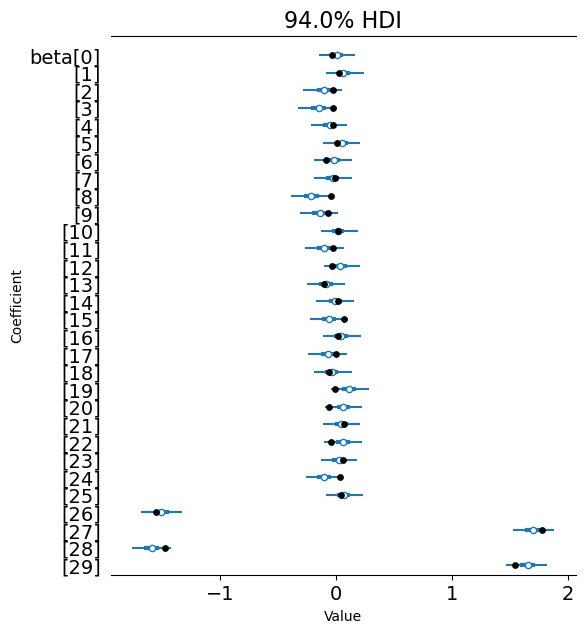

In [7]:
ax = az.plot_forest(idata_r2d2, var_names="beta", combined=True)[0]
ax.scatter(TRUE_BETAS, ax.get_yticks()[::-1], color="black", s=15, zorder=10)
ax.set(xlabel="Value", ylabel="Coefficient");

In [8]:
def get_conditional_R2(mean, variance):
    # A helper to get the conditional R^2
    mu_var = mean.var("__obs__")
    return mu_var / (mu_var + variance)

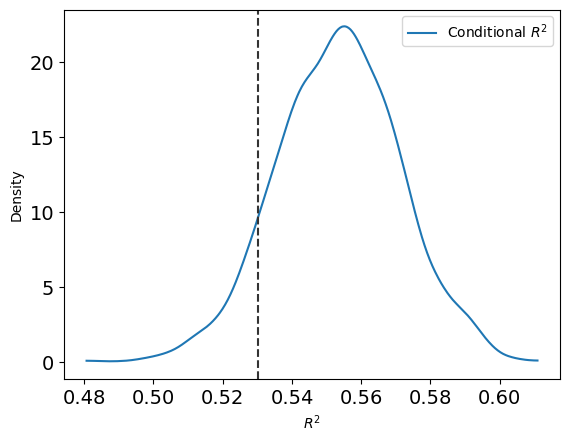

In [9]:
ax = az.plot_dist(get_conditional_R2(idata_r2d2.posterior["mu"], idata_r2d2.posterior["sigma_squared"]), label="Conditional $R^2$")
ax.axvline(TRUE_R2, color="0.2", ls="--")
ax.set(xlabel="$R^2$", ylabel="Density");

## R2-D2 for GLMMs

The R2-D2 prior for Generalized Linear Mixed Models (GLMMs) has been introduced in the paper [The R2D2 Prior for Generalized Linear Mixed Models](https://arxiv.org/abs/2111.10718) by Yanchenko et al. (2021).

Suppose we have a GLMM of the form:

$$
\begin{aligned}
Y_i \mid \mu_i, \theta &\underset{iid}{\sim} \text{Distribution}(\mu_i, \theta) \\
g(\mu_i) = \eta_i &= \alpha + \boldsymbol{x}_i \boldsymbol{\beta} + \sum_{k=1}^{q}u_{k g_k[i]} \\
\end{aligned}
$$

Let's be super clear about what we have in there:

There are $n$ observations indexed by $i \in \{1,\dots,n\}$. The response for observation $i$ is denoted $Y_i$, with mean $\mu_i$. Conditional on $\mu_i$, and possibly additional parameters $\theta$, the responses $Y_i$ are assumed to be independent and identically distributed. A link function $g(\cdot)$ relates the mean $\mu_i$ to the linear predictor $\eta_i$.

The linear predictor consists of an intercept $\alpha$, $p$ explanatory variables, and $q$ types of random effects.
For the $i$-th observation, the covariates are collected in the vector $\boldsymbol{x}_i = (x_{i1},\dots,x_{ip})$,
and the full set of covariates for all observations forms the design matrix $\boldsymbol{X}$, of dimension $n \times p$.
It is assumed that $\boldsymbol{X}$ has been standardized so that each column has mean zero and variance one.

The fixed-effect coefficients form the vector $\boldsymbol{\beta} = (\beta_1, \dots, \beta_p)^T$.
For the $k$-th random effect, there are $L_k$ levels collected in $\boldsymbol{u}_k = (u_{k1},\dots,u_{kL_k})^T$,
and we use $g_k[i]$ indicate the level of the random effect $k$ for the observation $i$.

To construct the R2D2 prior for GLMMs, Yanchenko et. al. (2021) specify the following prior model:

$$
\begin{aligned}
\beta_j \mid \phi_j, W &\underset{iid}{\sim}\text{Normal}(0, \phi_j W) \\
\boldsymbol{u}_k \mid \phi_{p + k}, W &\underset{iid}{\sim}\text{Normal}(0, \phi_{p + k}W \boldsymbol{I}_{L_k})
\end{aligned}
$$

The parameter $W > 0$ controls the overall variance of the linear predictor, controlling the total amount of variation in the fixed and random effects.
Larger values of $W$ correspond to more flexible models, while smaller values shrink the model toward an intercept-only model.

The parameters $\phi_j \ge 0$, which satisfy $\sum_{j=1}^{p+q} \phi_j = 1$, determine how this total variance $W$ is distributed across the individual fixed and random effect components.
The vector of variance proportions $\boldsymbol{\phi} = (\phi_1,\dots,\phi_{p+q})$ is typically given a Dirichlet prior,

$$
\boldsymbol{\phi} \sim \text{Dirichlet}(\xi_1, \dots, \xi_{p+q})
$$

and in many applications all concentration parameters are set to a common value $\xi_0$.
Larger values of $\xi_0$ shrink the variance proportions toward the uniform allocation $1/(p+q)$,
while smaller values allow for more dispersed and uncertain allocations across components.

Like in the linear model case, the R2-D2 prior for GLMMs is specified by placing a prior on the marginal $R^2$ that averages over explanatory variables and random effects ($\boldsymbol{X}$ and $\boldsymbol{g}$) as well as parameters ($\boldsymbol{\beta}$ and $\boldsymbol{u}_k$).

The marginal $R^2$ is defined as:

$$
R^2 = \frac{\mathbb{V}(\mathbb{E}(Y \mid \eta))}{\mathbb{V}(\mathbb{E}(Y \mid \eta)) + \mathbb{E}(\mathbb{V}(Y \mid \eta))}
$$

Since $R^2$ is based on summaries of the distribution of the linear predictor $\eta$, and $\eta_i \mid \alpha, W \sim \text{Normal}(\alpha, W)$, it also depends on the parameters $\alpha$ and $W$.

The essence of the R2-D2 prior for GLMMs is to define a joint prior on $(\alpha, W)$ such that the resulting induced prior on $R^2$ is $\text{Beta}(a, b)$.

Yanchenko et al. (2021) construct such a prior by decomposing the joint distribution into a marginal prior for $\alpha$ and a conditional prior for $W \mid \alpha$.
They then choose a prior for $W \mid \alpha$ that ensures the induced distribution of $R^2$ is $\text{Beta}(a, b)$ for any fixed value of $\alpha$.
Because this holds conditionally for all $\alpha$, the marginal distribution of $R^2$ under the joint prior on $(\alpha, W)$ is also $\text{Beta}(a, b)$,
regardless of the marginal prior placed on $\alpha$.
Combined with a Dirichlet prior on the variance proportions, this construction yields the R2-D2 prior for GLMMs.

For some model families, the prior on $W$ that induces $R^2 \sim \text{Beta}(a, b)$ can be derived in closed form. However, since this is not generally possible for GLMMs, the authors propose a unified approximate approach that works across all model families.

The idea is to place a Generalized Beta Prime (GBP) prior on $W$ and choose its parameters so that the resulting induced distribution of $R^2$ closely matches the target $\text{Beta}(a, b)$ distribution.

The problem is then to find the values of $(a^*, b^*, c^*, d^*)$ so that the prior $W \sim \text{GBP}(a^*, b^*, c^*, d^*)$ induces a prior on $R^2$ that is close to $\text{Beta}(a, b)$.

Let $W \sim p(w)$ be the distribution that yields exactly $R^2 \sim \text{Beta}(a, b)$.

The parameters of the GBP distribution are obtained by minimizing the Pearson $\chi^2$ divergence between the true density $p(w)$ and its GBP approximation $f_{GBP}$,
with an added regularization term that shrinks the solution toward $\text{GBP}(a^*, b^*, 1, 1)$,
which is the exact solution for certain model families and can be considered the baseline.

The optimization problem is:
$$
\begin{aligned}
(a^*, b^*, c^*, d^*)
& =
    \arg\min_{\alpha, \beta, c, d} \left[
        \int_0^{\infty}
        \left\{
            \frac{f_{GBP}(w, \alpha, \beta, c, d) - p(w)}{p(w)}
        \right\}^2
        p(w) dw + \lambda
    \left[
        (\alpha - a)^2 + (\beta - b)^2 + (c - 1)^2 + (d - 1)^2
    \right]
\right]
\end{aligned}
$$

Here, $\lambda \ge 0$ is a tuning parameter that controls the amount of the regularization,
which the authors suggest setting to $\lambda = \frac{1}{4}$.

In practice, specifying the R2-D2 prior for GLMMs requires the user to choose the Beta hyperparameters $a$ and $b$ for the desired prior on $R^2$.
On then solves the optimization problem above to find the parameters $(a^*, b^*, c^*, d^*)$ of the GBP prior on $W$.
The resulting prior can be implemented via the transformation:

$$
V \sim \text{Beta}(a^*, b^*) \implies W = d^*\left[\frac{V}{1 - V}\right]^{1/c^*} \sim \text{GBP}(a^*, b^*, c^*, d^*)
$$

Because the optimal values $(a^*, b^*, c^*, d^*)$ depend on $\alpha$ and possibly other response-distribution parameters $\theta$,
the approximation should be updated with their values at every MCMC iteration.
However, performing this optimization at every MCMC iteration would be computationally infeasible.
To address this, the authors recommend computing the GBP approximation once at the start of the analysis using $\hat{\alpha} = g(\bar{Y}_i)$ and, if needed, the maximum likelihood estimate $\hat{\theta}$.
Once the values of $(a^*, b^*, c^*, d^*)$ are found, $\alpha$ and $\theta$ are treated as unknown again during the subsequent Bayesian inference.

### Finding the GBP parameters

To Do: Update it to work with arbitrary families.

In [10]:
import numpy as np
from scipy import stats
from scipy.optimize import minimize, minimize_scalar
from scipy import special


def dgbetapr(x, a, b, c, d):
    # Equation in Yanchenko et al. (2021)
    return c * (x / d) ** (a * c - 1) * (1 + (x / d) ** c) ** (-a - b) / (d * special.beta(a, b))

def qmc_mean(x, b0, m=1, K=1000):
    # Equation 11 in Yanchenko et al. (2021)
    p_grid = np.linspace(1, K - 1, num=K - 1) / K
    eta = stats.norm(loc=b0, scale=x ** 0.5).ppf(p_grid)
    mu = special.expit(eta)
    return np.mean(mu ** m).item()

def qmc_var(x, b0, K=1000):
    # Equation 12 in Yanchenko et al. (2021)
    p_grid = np.linspace(1, K - 1, num=K - 1) / K
    eta = stats.norm(loc=b0, scale=x ** 0.5).ppf(p_grid)
    mu = special.expit(eta)
    return np.mean(mu * (1 - mu))

def W_to_R2_scalar(x, b0):
    # Equation 13 in Yanchenko et al. (2021)
    mu_1 = qmc_mean(x=x, b0=b0, m=1, K=1000)
    mu_2 = qmc_mean(x=x, b0=b0, m=2, K=1000)
    sigma_squared = qmc_var(x=x, b0=b0, K=1000)

    # Usage of M and V comes from Equation 3
    M = mu_2 - mu_1 ** 2
    V = sigma_squared

    return M / (M + V)

def W_to_R2(W, b0):
    # Vectorized version of Equation 13 in Yanchenko et al. (2021)
    return np.array([W_to_R2_scalar(w, b0) for w in np.atleast_1d(W)])

def pw(w, a, b, b0):
    # Cumulative Distribution Function (CDF) of W
    # Computes values of the CDF of W induced by a Beta(a, b) prior on R2.
    # The strategy is to convert W to R2 and find the CDF of the corresponding R2
    R2 = W_to_R2(w, b0)
    return stats.beta.cdf(R2, a=a, b=b)

def dw(w, a, b, b0):
    # Density function of W
    # Computes values of the density function of W induced by a Beta(a, b) prior on R2.

    # The computation uses a numeric approxiation to the derivative of the CDF.
    delta = 0.001
    diff = pw(w=w + delta, a=a, b=b, b0=b0) - pw(w=w - delta, a=a, b=b, b0=b0)
    return diff / (2 * delta)


def qw(p, a, b, b0):
    # Quantile Function of W
    # Computes the quantiles of W induced by a Beta(a,b) prior on R2.

    # Numerically inverts the CDF
    def inner(p):
        def distance(logw):
            return (pw(w=np.exp(logw), a=a, b=b, b0=b0) - p) ** 2

        output = minimize_scalar(
            distance,
            bounds=(np.log(1/100000), np.log(100000)),
            method="bounded"
        ).x

        return np.exp(output)

    return np.array([inner(p_i) for p_i in np.atleast_1d(p)])


def WGBP(a=1, b=1, b0=0, lam=0.25, x0=np.ones(4), method="Powell"):
    """Compute parameters for the GBP Approximation

    This function finds the closest generalized beta prime (GBP) distribution to the true
    pdf of W as measured by the Pearson chi-squared divergence.
    """
    tau = np.linspace(0.01, 0.99, num=100)
    w = qw(p=tau, a=a, b=b, b0=b0).flatten()
    py = dw(w=w, a=a, b=b, b0=b0).flatten()

    def distance_fun(log_params):
        params = np.exp(log_params)
        px = dgbetapr(w, *params)
        log_target = np.log(np.array([a, b, 1, 1]))

        # I _think_ this is quasi monte carlo (shouldn't it be a mean?)
        # I would have gotten the expression for the argument as
        # (px/py - 1) ** 2, but the result is the same, so no problem.
        integral = np.mean((px / py - 1) ** 2)
        penalty = lam * np.sum((log_params - log_target) ** 2)
        distance = integral + penalty

        return distance

    result = minimize(distance_fun, x0=np.log(x0), method=method)

    if result.success:
        return np.exp(result.x)

    raise Exception("Minimization didn't converge")


params = WGBP(a=1, b=1, b0=0, lam=0.25)
params

array([1.45582929, 0.64874523, 0.79198358, 1.25236615])